# Computing distance figures from speeches

This notebooks reads embedded speech vectors and their metadata and computes different distance measures between the speeches

## Imports, methods etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle
from tqdm import tqdm

### Data reading

In [3]:
def read_sentiment_csv(path):
    
    df = pd.read_csv(path)
    return df

In [17]:
def read_embeddings(path):

    with (open(path, "rb")) as openfile:
        while True:
            try:
                embeddings = pickle.load(openfile)
            except EOFError:
                break

    return embeddings

### Filtering and merging dataframes

In [40]:
def filter_df(df):

    # check if Date_datetime column exists
    if 'Date_datetime' not in df.columns:
        df['Date_datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['speech_length'] = df['speech'].apply(lambda x: len(x) if type(x) == str else 0)
    # compute week
    df['week'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.week) if x.week > 9 else '0' + str(x.week)))
    df['month'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + (str(x.month) if x.month > 9 else '0' + str(x.month)))
    # #filter out speeches with less than 100 words
    df = df[df['speech_length'] > 200]
    #filter out speeches where the speaker is not a mp
    df = df[df['Speaker_MP'] == 'MP']
    df = df[df['Speaker_role'] == 'Regular']
    #reset index
    df = df.reset_index(drop=True)

    return df

In [18]:
def merge_embeds_and_df(df, embeddings):

    merged_df = df.merge(embeddings, left_on='ID', right_on=embeddings.index, how='inner')

    return merged_df

### Methods for monthly analysis

In [85]:
def new_monthly_analysis_df():

    return pd.DataFrame(columns=['month', 'cos_sim', 'party_distance', 'speaker_distance', 'number_of_speeches', 'sentiment'])

def new_speakers_df():

    return pd.DataFrame(columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])

def monthly_data(month, df):

    df_m = df[df['month'] == month]
    vectors_m = df_m['embeddings'].values
    vectors_m = np.array([np.array(x) for x in vectors_m])

    return df_m, vectors_m

def monthly_party_figures(df_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    parties = df_m['Speaker_party'].unique()
    #remove null party
    parties = [p for p in parties if str(p) != 'nan']
    #calculate mean vector for each party
    party_mean_vectors = []
    party_median_vectors = []
    for p in parties:
        #filter vectors to only include vectors where speaker party is p
        vectors_p = df_m[df_m['Speaker_party'] == p]['embeddings'].values
        vectors_p = np.array([np.array(x) for x in vectors_p])
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        party_mean_vectors.append(mean_vector_p)
        #calculate median vector for party p
        median_vector_p = np.median(vectors_p, axis=0)
        party_median_vectors.append(median_vector_p)
    #compute party weights
    party_weights = np.array([len(df_m[df_m['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_p - monthly_speech_mean_vector) for mean_vector_p in party_mean_vectors])
    party_distances = party_distances @ party_weights.T
    mean_weighted_party_distance = np.mean(party_distances)
    #compute party vector distances to median vector
    party_distances_median = np.array([np.linalg.norm(median_vector_p - monthly_speech_median_vector) for median_vector_p in party_median_vectors])
    median_party_distance = np.median(party_distances_median)

    return mean_weighted_party_distance, median_party_distance

def monthly_speaker_figures(df_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    #list distinct speakers in df_w
    speakers = df_m['Speaker_name'].unique()
    #new dataframe for speaker monthly stats
    speakers_monthly_stats = new_speakers_df()
    #calculate mean vector for each speaker
    speaker_mean_vectors = []
    speaker_median_vectors = []
    for s in speakers:
        #filter vectors to only include vectors where speaker is s
        vectors_s = df_m[df_m['Speaker_name'] == s]['embeddings'].values
        vectors_s = np.array([np.array(x) for x in vectors_s])
        #calculate mean vector for speaker s
        mean_vector_s = np.mean(vectors_s, axis=0)
        speaker_mean_vectors.append(mean_vector_s)
        #calculate median vector for speaker s
        median_vector_s = np.median(vectors_s, axis=0)
        speaker_median_vectors.append(median_vector_s)
        #add speaker to df_speakers
        speaker_row = pd.DataFrame([[s, m, np.linalg.norm(mean_vector_s - monthly_speech_mean_vector), len(vectors_s)]], columns=['Speaker_name', 'month', 'monthly_distance', 'number_of_speeches'])
        speakers_monthly_stats = pd.concat([speakers_monthly_stats, speaker_row])
    #compute speaker weights
    speaker_weights = np.array([len(df_m[df_m['Speaker_name'] == s]) for s in speakers])
    speaker_weights = speaker_weights / np.sum(speaker_weights)
    #compute speaker vector distances to mean vector
    speaker_distances = np.array([np.linalg.norm(mean_vector_s - monthly_speech_mean_vector) for mean_vector_s in speaker_mean_vectors])
    speaker_distances = speaker_distances @ speaker_weights.T
    spkrm = np.sum(speaker_distances)
    #compute speaker vector distances to median vector
    speaker_distances_median = np.array([np.linalg.norm(median_vector_s - monthly_speech_median_vector) for median_vector_s in speaker_median_vectors])
    spkr_median = np.median(speaker_distances_median)

    return spkrm, spkr_median, speakers_monthly_stats

def monthly_cosine_similarities(vectors_m, monthly_speech_mean_vector, monthly_speech_median_vector):

    #calculate cosine similarities
    
    monthly_cos_sim_to_mean = cosine_similarity(vectors_m, monthly_speech_mean_vector.reshape(1, -1))
    monthly_cos_sim_m_to_median = cosine_similarity(vectors_m, monthly_speech_median_vector.reshape(1, -1))
    #calculate mean and median cosine similarities
    mean_cos_sim = np.mean(monthly_cos_sim_to_mean)
    median_cos_sim = np.median(monthly_cos_sim_m_to_median)
    
    return mean_cos_sim, median_cos_sim

def monthly_sentiment(df_m):

    return np.mean(df_m['sentiment']), np.median(df_m['sentiment'])

### Plots

In [119]:
def plot_monthly(df, partydistance):

    monthly = df.sort_values(by=['month']).reset_index(drop=True)
    monthly['party_distance_norm'] = monthly['party_distance'] / np.max(monthly['party_distance'])
    monthly['speaker_distance_norm'] = monthly['speaker_distance'] / np.max(monthly['speaker_distance'])

    fig, ax1 = plt.subplots(figsize=(40, 24))
    ax2 = ax1.twinx()

    ax1.plot(monthly['month'], monthly['cos_sim'], linewidth=3)
    ax1.plot(monthly['month'], monthly['speaker_distance_norm'], linewidth=3)
    ax1.plot(monthly['month'], monthly['sentiment'], linewidth=3, color='red')
    ax2.bar(monthly['month'], monthly['number_of_speeches'], alpha=0.3)
    if(partydistance):
        ax1.plot(monthly['month'], monthly['party_distance_norm'], linewidth=3)
    fig.autofmt_xdate()
    ax1.grid(color='grey', linestyle='-', linewidth=1, alpha=0.3)
    labels = ['Cosine similarity', 'Speaker distance', 'Sentiment']
    if(partydistance):
        labels.append('Party distance')
    ax1.legend(labels = labels, loc='upper left', fontsize=30)
    ax2.legend(labels = ['Number of speeches'], loc='upper right', fontsize=30)
    plt.show()

## Running the Analysis

### Data locations

In [98]:
__location__ = os.path.abspath("")
sentiment_path = os.path.join(__location__, '..', 'data', 'DHH23_csvs_with_sentiment', 'ParlaMint-GB-commons_with_sentiment.csv')
speaker_dump_path = os.path.join(__location__, '..', 'data', 'speakers.csv')
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_GB_commons_embeddings_truncated.pkl'))


### Read sentiment CSV

In [96]:
df = read_sentiment_csv(sentiment_path)
#filter the dataframe
df = filter_df(df)
df.head()
print(len(df))

379562


### Read the embedded vectors

In [99]:
embeddings = read_embeddings(pklpath)
df_embeddings = pd.DataFrame(index=embeddings.keys())
df_embeddings['embeddings'] = embeddings.values()
df_embeddings.head(2)
print(len(df_embeddings))

472782


### Merge data frames

In [100]:
mergeddf = merge_embeds_and_df(df, df_embeddings)
mergeddf.head(2)


,Unnamed: 0,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,...,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,Date_datetime,speech_length,week,month,embeddings
0,2,ParlaMint-GB_2017-11-20-commons.u3,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,...,F,-,May I take this opportunity to add my good wis...,NaN,-0.216431,2017-11-20,510,2017-47,2017-11,"[0.127124, 0.031141866, -0.0068759085, 0.01661..."
1,3,ParlaMint-GB_2017-11-20-commons.u4,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,...,M,-,My constituents in Yateley woke up to a nightm...,Some of them were as young as 12 and from out...,-0.996094,2017-11-20,458,2017-47,2017-11,"[0.027221974, 0.08362359, -0.0067807273, 0.003..."


### Run monthly analysis

In [101]:
#list distinct months in df
months = mergeddf['month'].unique()
#initialize dfs for storing results
monthly_means = new_monthly_analysis_df()
monthly_medians = new_monthly_analysis_df()
df_speakers = new_speakers_df()

#iterate over months
for m in tqdm(months):
    #filter df to only include speeches in month m
    df_m, vectors_m = monthly_data(m, mergeddf)
    number_of_speeches = len(df_m)
    
    #calculate mean, median vector for month m
    mean_vector_m = np.mean(vectors_m, axis=0)
    median_vector_m = np.median(vectors_m, axis=0)
    
    #calculate mean, median distances for parties, speakers
    weighted_mean_party_distance, median_party_distance = monthly_party_figures(df_m, mean_vector_m, median_vector_m)
    weighted_mean_speaker_distance, median_speaker_distance, speakers_monthly_stats = monthly_speaker_figures(df_m, mean_vector_m, median_vector_m)
    df_speakers = pd.concat([df_speakers, speakers_monthly_stats])
    
    #compute mean cosine similarity for month m
    mean_cos_sim, median_cos_sim = monthly_cosine_similarities(vectors_m, mean_vector_m, median_vector_m)

    #compute mean, median sentiment for month m
    mean_sentiment, median_sentiment = monthly_sentiment(df_m)

    #concatenate monthly means
    monthly_mean_row = pd.DataFrame([[m, mean_cos_sim, weighted_mean_party_distance, weighted_mean_speaker_distance, number_of_speeches, mean_sentiment]], columns=monthly_means.columns)
    monthly_means = pd.concat([monthly_means, monthly_mean_row])
    
    #concatenate monthly medians
    monthly_median_row = pd.DataFrame([[m, median_cos_sim, median_party_distance, median_speaker_distance, number_of_speeches, median_sentiment]], columns=monthly_medians.columns)
    monthly_medians = pd.concat([monthly_medians, monthly_median_row])

df_speakers['monthly_mean_distance'] = df_speakers['monthly_distance'] / df_speakers['number_of_speeches']

100%|██████████| 83/83 [00:55<00:00,  1.49it/s]


### Plot mean figures

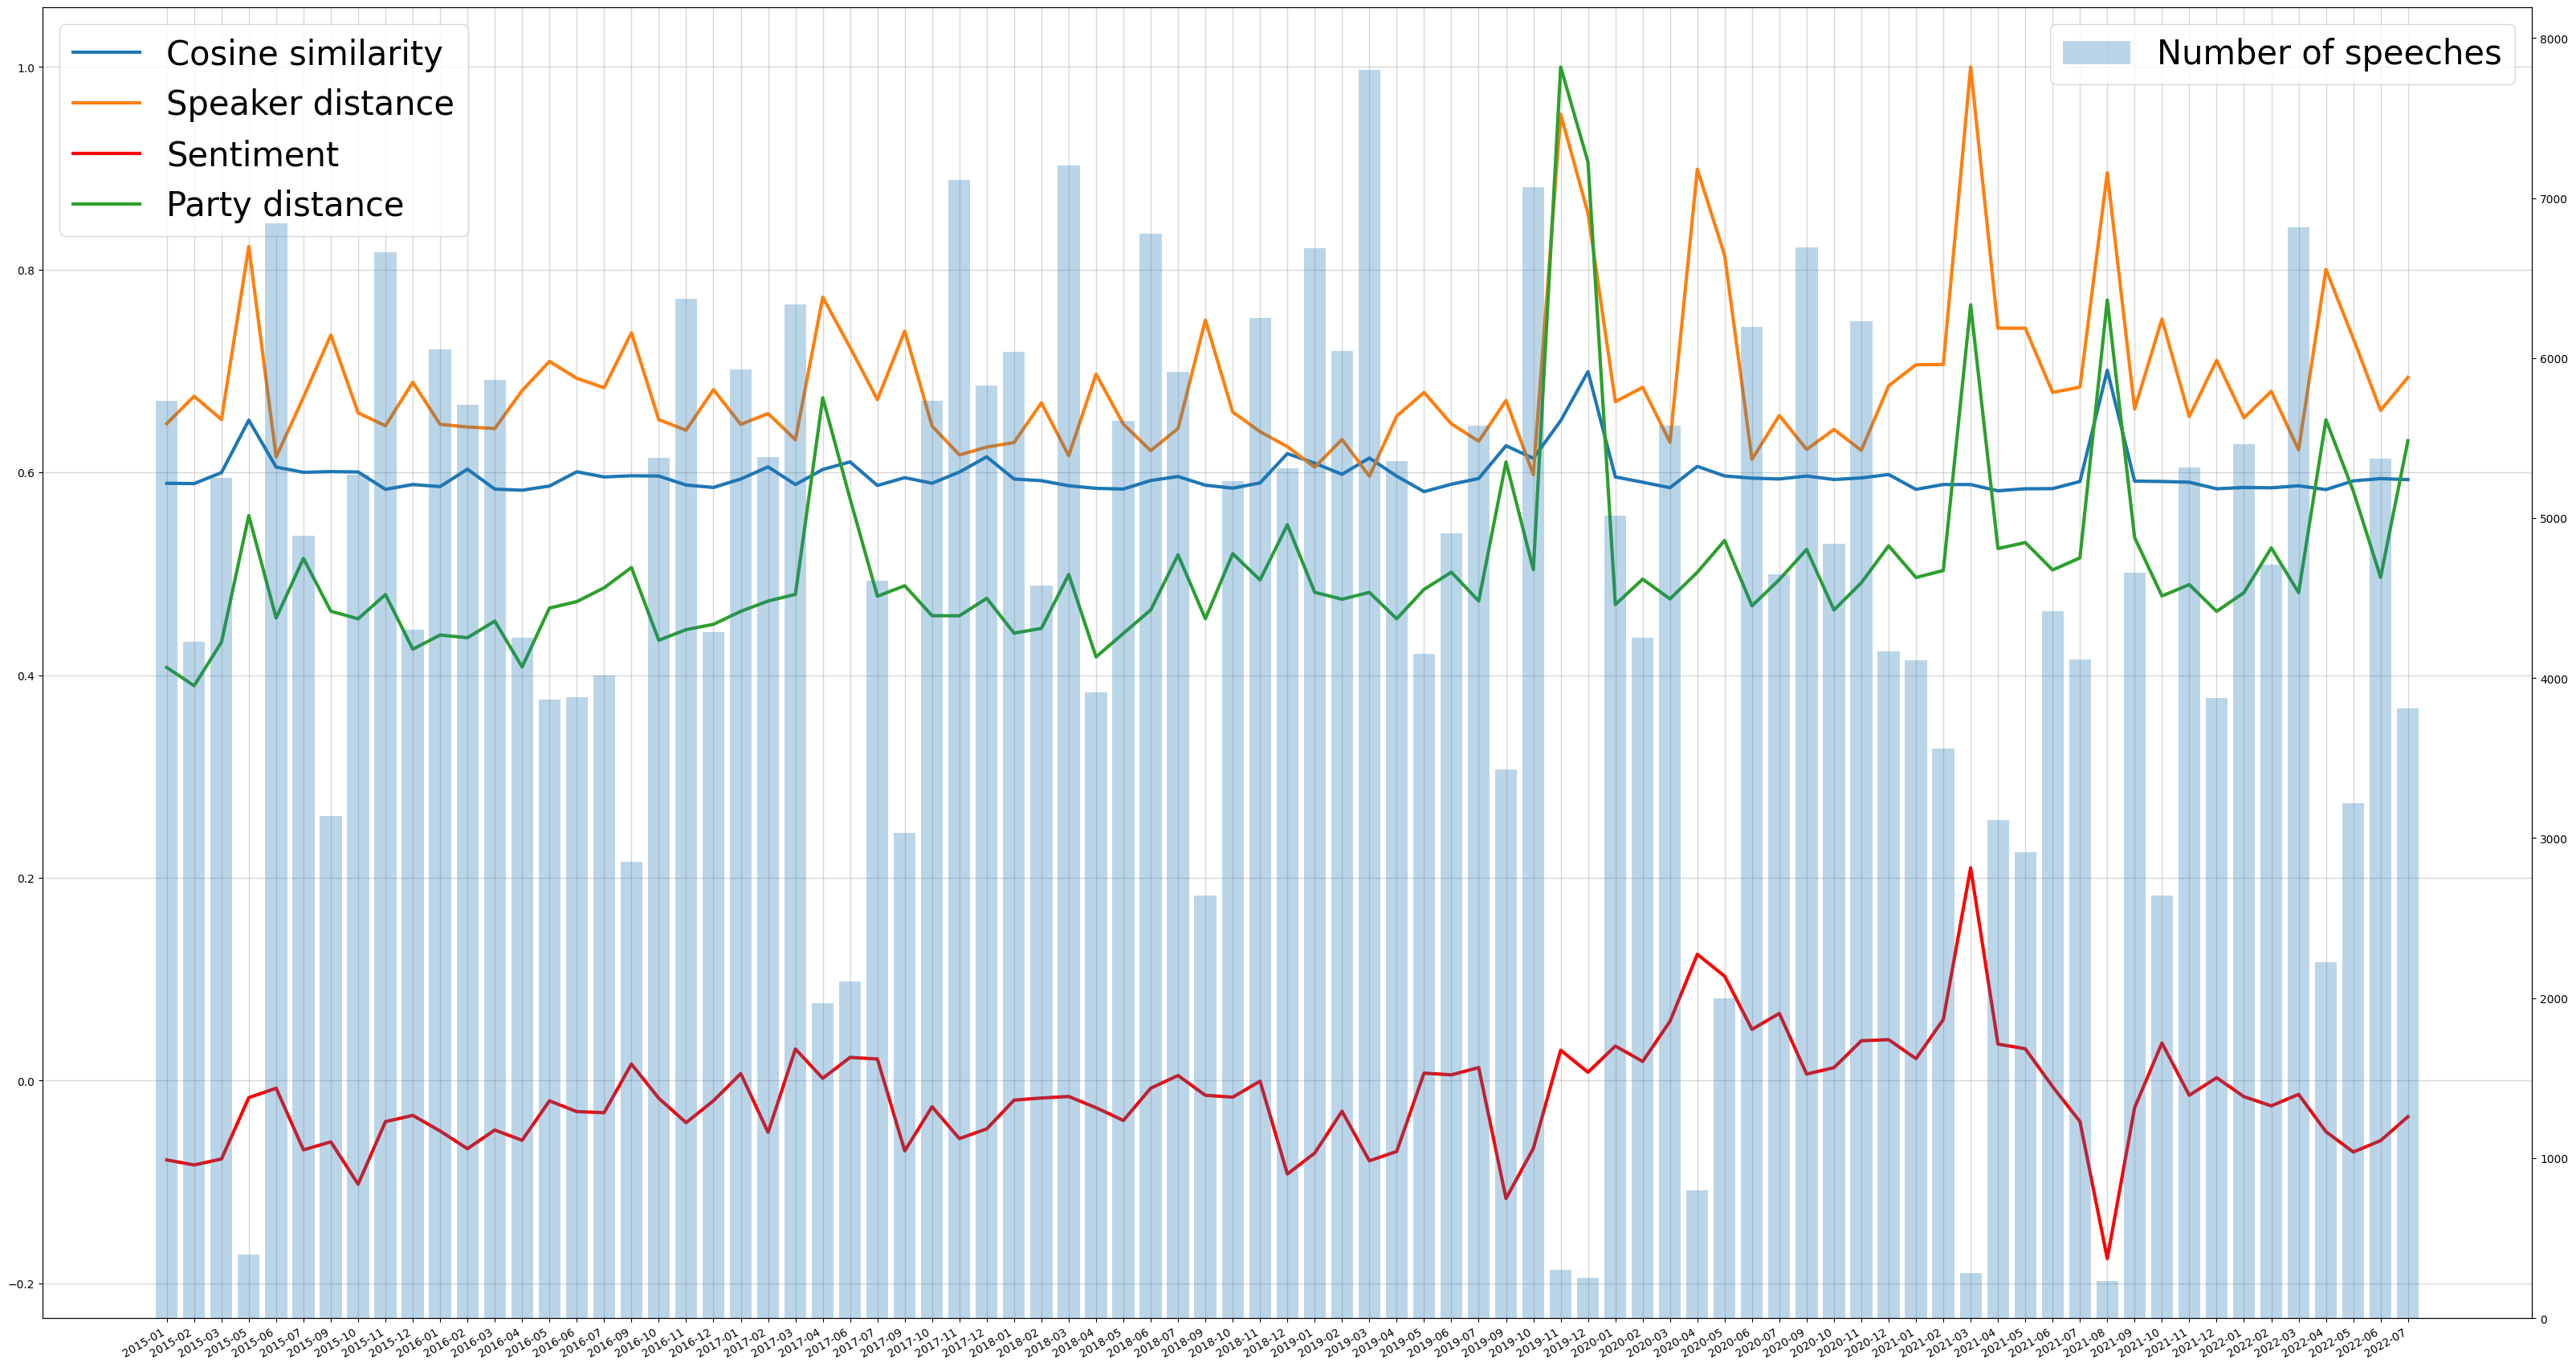

In [121]:
plot_monthly(monthly_means, True)


### Plot median figures

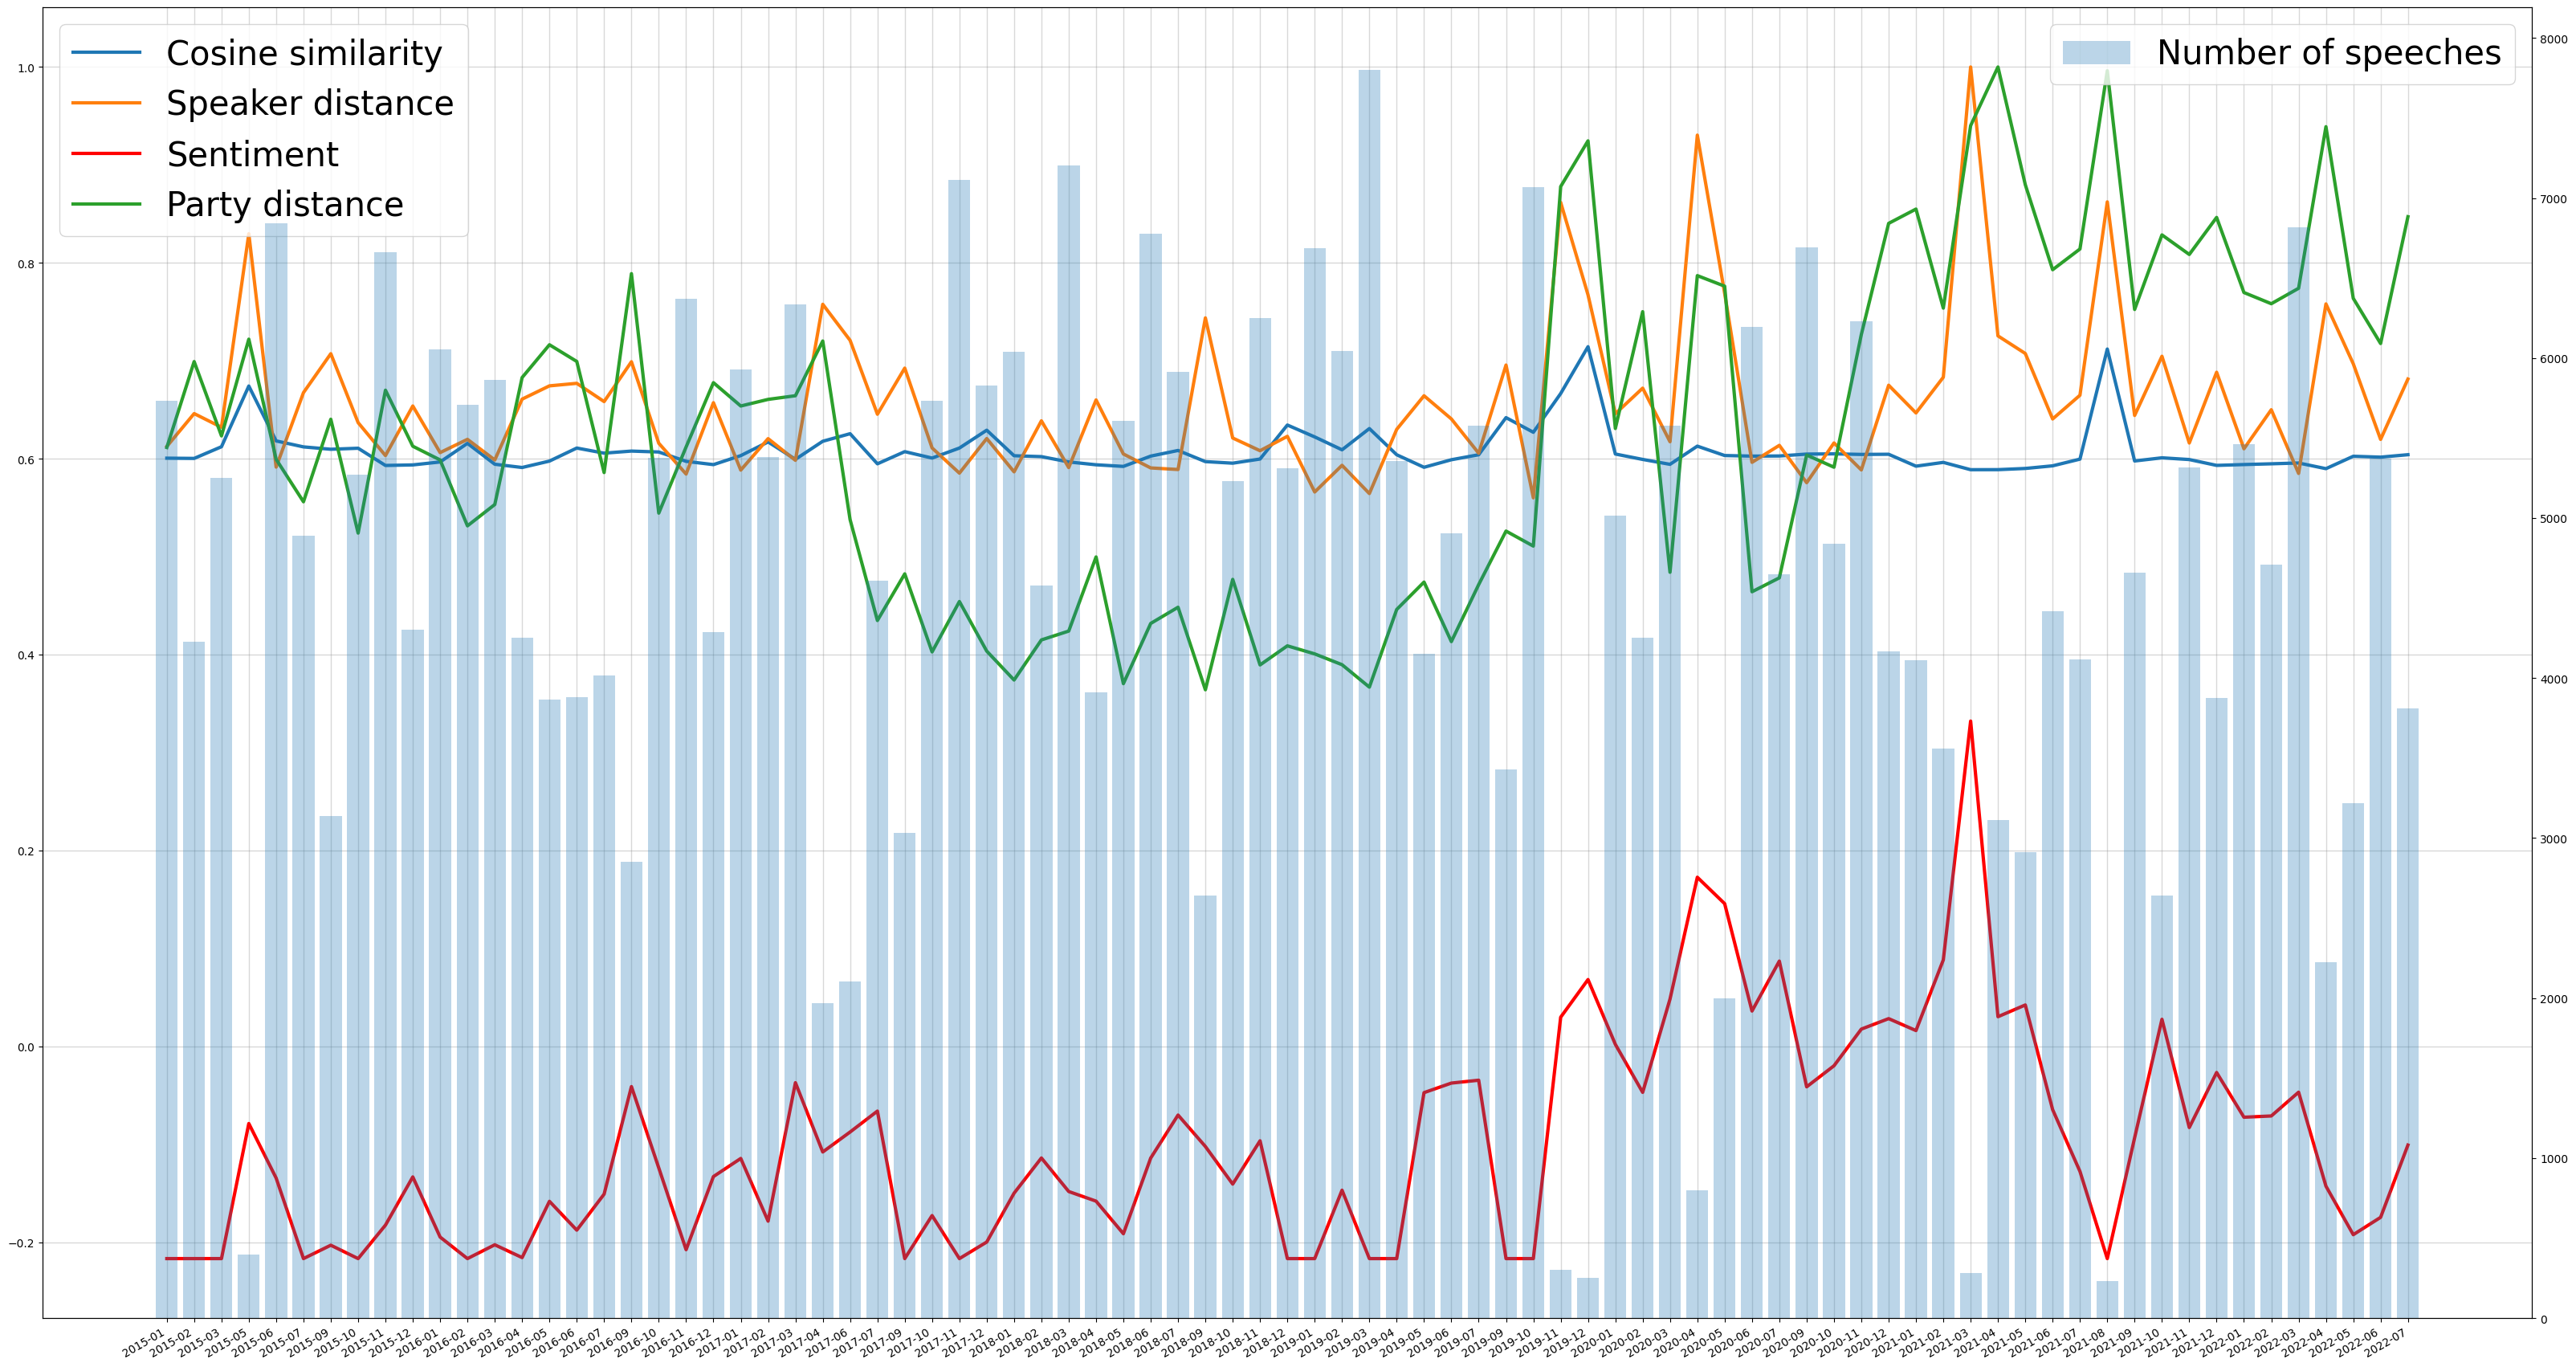

In [120]:
plot_monthly(monthly_medians, True)

## Save Speakers CSV

In [11]:
# save speakers csv
df_speakers.to_csv(speaker_dump_path, index=False)